# Table of Contents

- In this notebook, we'll learn about:
- Topic Modelling
  - Latent Dirichlet Allocation (LDA)
  - Truncated SVD (Truncated Singular Value Decomposition)

- Dimension Reduction
  - Principal Component Analysis (PCA)
  - Linear Discriminant Analysis (LDA)
  - Truncated SVD (Truncated Singular Value Decomposition)

<br>

## Topic Modelling

- Topic modeling in NLP discovers abstract themes in document collections using algorithms like LDA (Latent Dirichlet Allocation), LSA (Latent Semantic Analysis), etc. 
- It's unsupervised, clusters similar expressions, and aids in organizing, summarizing, and analyzing large text datasets.

In [1]:
%load_ext watermark
%watermark -v -p numpy,pandas,polars,omegaconf --conda

Python implementation: CPython
Python version       : 3.11.8
IPython version      : 8.22.2

numpy    : 1.26.4
pandas   : 2.2.1
polars   : 0.20.18
omegaconf: 2.3.0

conda environment: torch_p11



In [2]:
# Built-in library
from pathlib import Path
import re
import json
from typing import Any, Literal, Optional, Union
import logging
import warnings

# Standard imports
import numpy as np
import numpy.typing as npt
from pprint import pprint
import pandas as pd
import polars as pl

# Visualization
import matplotlib.pyplot as plt

# NumPy settings
np.set_printoptions(precision=4)

# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

# Polars settings
pl.Config.set_fmt_str_lengths(1_000)
pl.Config.set_tbl_cols(n=1_000)
pl.Config.set_tbl_rows(n=200)

warnings.filterwarnings("ignore")

# Black code formatter (Optional)
%load_ext lab_black

# auto reload imports
%load_ext autoreload
%autoreload 2

In [3]:
from rich.console import Console
from rich.panel import Panel
from rich.text import Text
from rich.table import Table
from rich import box
from rich.theme import Theme

custom_theme = Theme(
    {
        "white": "#FFFFFF",  # Bright white
        "info": "#00FF00",  # Bright green
        "warning": "#FFD700",  # Bright gold
        "error": "#FF1493",  # Deep pink
        "success": "#00FFFF",  # Cyan
        "highlight": "#FF4500",  # Orange-red
    }
)

console = Console(theme=custom_theme)


def fancy_print(
    object: Any,
    title: str = "Result",
    border_style: str = "bright_green",
    content_style: str | None = None,
    show_type: bool = True,
    expand: bool = False,
    return_panel: bool = False,
) -> Panel | None:

    if isinstance(object, dict):
        content = Table(show_header=False, box=box.SIMPLE)
        for key, value in object.items():
            content.add_row(
                Text(str(key), style="cyan"),
                Text(str(value), style=content_style or "white"),
            )
    elif isinstance(object, (list, tuple)):
        content = Table(show_header=False, box=box.SIMPLE)
        for i, item in enumerate(object):
            content.add_row(
                Text(str(i), style="cyan"),
                Text(str(item), style=content_style or "white"),
            )
    else:
        content = Text(str(object), style=content_style or "white")

    if show_type:
        title = f"{title} ({type(object).__name__})"

    panel = Panel(
        content,
        title=title,
        title_align="left",
        border_style=border_style,
        expand=expand,
    )
    if return_panel:
        return panel
    else:
        console.print(panel)
        return None


# Example usage
console.print("hello, world!")
fancy_print({"message": "Good morning!", "name": "John"})

hello, world!

╭─ Result (dict) ─────────────╮
│                             │
│   message   Good morning!   │
│   name      John            │
│                             │
╰─────────────────────────────╯

### Latent Dirichlet Allocation (LDA)

- LDA is a generative probabilistic model that tries to find groups of words that appear frequently together across different documents.
- It assumes that each document is a mixture of topics, and each topic is a distribution over words.
- LDA assumes documents are "bags of words." i.e. the order of words doesn't matter, and only the frequency of word occurrences is considered.
  - This is a simplification, as word order can be important for understanding meaning.

In [4]:
fp: str = "../../data/ImDB_data.parquet"
df: pl.DataFrame = pl.read_parquet(fp)
fancy_print(df.shape[0], title="Number of rows")

df.head(2)

╭─ Number of rows (int) ─╮
│ 50000                  │
╰────────────────────────╯

review,sentiment
str,i64
"""I felt this movie was as much about human sexuality as anything else, whether intentionally or not. We are also shown how absurd and paradoxical it is for women not to be allowed to such a nationally important event, meanwhile forgetting the pasts of our respective ""advanced"" nations. I write from Japan, where women merely got the right to vote 60 years ago, and female technical engineers are a recent phenomenon. Pubs in England were once all-male, the business world was totally off-limits for women in America until rather recently, and women in China had their feet bound so they couldn't develop feet strong enough to escape their husbands. Iran is conveniently going through this stage in our time, and we get a good look at how ridiculous we have all looked at one time or another. Back to the issue of sexuality, we are made to wonder what it may be intrinsically about women that make them unfit for a soccer game (the official reason is that the men are bad). Especially such boyish gir…",1
"""Let's face it, a truly awful movie, no...I mean a ""truly"" awful movie, is a rare, strange, and beautiful thing to behold. I admite that there is a special place in my heart for films like Plan 9 From Outer Space, Half Caste, Species, etc. And although I'm giving this film a 1, I highly urge anyone who enjoys a bad film for what it truly is (a bad film) to find a friend, snacks, something to drink, and make the special occasion it deserves out of: Aussie Park Boyz. <br /><br />From the very first moments of the lead actor's side to side eye-rolling performance as he attempts to inject intensity directly into the film without ever looking at a camera (a slice of ham straight out of silent pictures--eat your heart out Rudolph Valentino) to the sudden hey-we're-out-of-film conclusion, you...will...not...stop...laughing. <br /><br />To sum the film up, its a poor man's Warriors down under, complete--and that description alone should be enough, but then comes the wonders of ""the spaghetti e…",0


In [5]:
from itertools import chain
from collections import Counter
import spacy
from spacy.tokens import Doc, Token

from utils.utils import (
    infer_stopwords,
    MyCorpus,
    preprocess,
    spacy_tokenizer,
    spacy_preprocess,
    create_wordcloud,
)
from utils.topic_modelling import LdaTopicExtractor

nlp = spacy.load("en_core_web_sm")

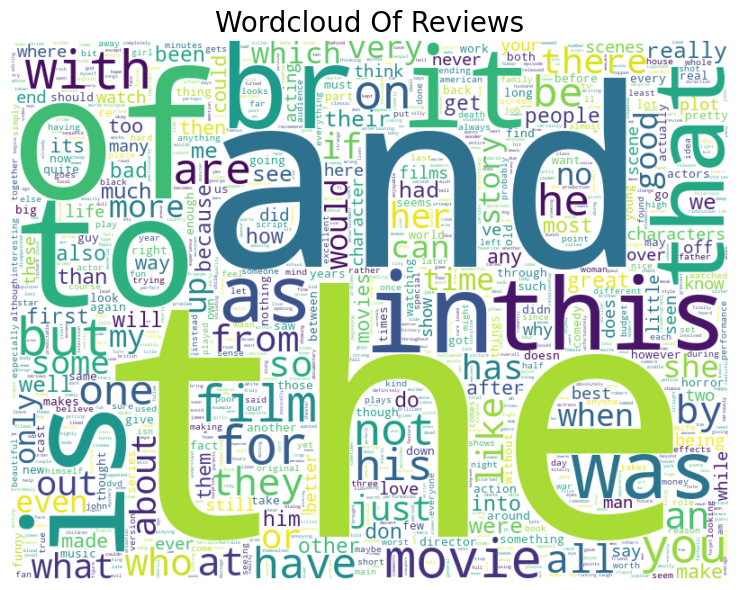

In [6]:
corpus: list[list[str]] = [preprocess(doc) for doc in df["review"].to_list()]
counter = Counter(chain.from_iterable(corpus))
create_wordcloud(counter, title="Wordcloud of reviews")

In [7]:
corpus: list[list[str]] = [preprocess(doc) for doc in df["review"].to_list()]
stopwords: set[str] = infer_stopwords(corpus, threshold_percentage=0.4)

fancy_print(
    object=str(sorted(stopwords)),
    title="[BEFORE]: Stopwords",
    border_style="bright_red",
)

try:
    for word in ["good", "film", "like", "movie", "story", "time"]:
        stopwords.remove(word)


except KeyError as e:
    console.print(f"[WARNING]: {e}", style="warning")
    pass
fancy_print(object=str(sorted(stopwords)), title="[AFTER]: Stopwords")

fancy_print(object=len(corpus))

╭─ [BEFORE]: Stopwords (str) ─────────────────────────────────────────────────────────────────────────────────────╮
│ ['about', 'all', 'an', 'and', 'are', 'as', 'at', 'be', 'br', 'but', 'by', 'can', 'even', 'film', 'for', 'from', │
│ 'good', 'had', 'has', 'have', 'he', 'her', 'his', 'if', 'in', 'is', 'it', 'just', 'like', 'me', 'more',         │
│ 'movie', 'my', 'no', 'not', 'of', 'on', 'one', 'only', 'or', 'out', 'really', 'see', 'she', 'so', 'some',       │
│ 'story', 'that', 'the', 'their', 'there', 'they', 'this', 'time', 'to', 'up', 'very', 'was', 'we', 'well',      │
│ 'were', 'what', 'when', 'which', 'who', 'with', 'would', 'you']                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─ [AFTER]: Stopwords (str) ──────────────────────────────────────────────────────────────────────────────────────╮
│ ['about', 'all', 'an', 'and', 'are', 'as', 'at', 'be', 'br', 'but', 'by', 'can', 'even', 'for', 'from', 'had',  │
│ 'has', 'have', 'he', 'her', 'his', 'if', 'in', 'is', 'it', 'just', 'me', 'more', 'my', 'no', 'not', 'of', 'on', │
│ 'one', 'only', 'or', 'out', 'really', 'see', 'she', 'so', 'some', 'that', 'the', 'their', 'there', 'they',      │
│ 'this', 'to', 'up', 'very', 'was', 'we', 'well', 'were', 'what', 'when', 'which', 'who', 'with', 'would',       │
│ 'you']                                                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─ Result (int) ─╮
│ 50000          │
╰────────────────╯

In [8]:
# updated_corpus: list[list[str]] = [
#     preprocess(token, custom_stopwords=stopwords) for doc in corpus for token in doc
# ]

updated_corpus = [
    preprocess(" ".join(doc), custom_stopwords=stopwords) for doc in corpus
]
corpus_iterator = MyCorpus(updated_corpus)
fancy_print(object=corpus_iterator)

╭─ Result (MyCorpus) ─────────────────────────╮
│ MyCorpus(in-memory data, data=50,000 items) │
╰─────────────────────────────────────────────╯

In [9]:
# This cell took ~14 mins to run.

topic_extractor: LdaTopicExtractor = LdaTopicExtractor(
    corpus=corpus_iterator,
    num_topics=10,
    iterations=20,  # small value due to large corpus
    passes=20,  # small value due to large corpus
)
topic_extractor.train_model()
topics = topic_extractor.extract_topics()
topic_extractor.print_topics(topics)
coherence, perplexity = topic_extractor.evaluate_lda()

LDA model trained.

Average topic coherence: -1.7308

[
    (
        [
            (0.013154616, 'people'),
            (0.00973843, 'how'),
            (0.008815002, 'will'),
            (0.008376724, 'them'),
            (0.00785805, 'us'),
            (0.007646427, 'life'),
            (0.0070462725, 'these'),
            (0.0070082205, 'other'),
            (0.0064866384, 'do'),
            (0.0062983194, 'like')
        ],
        -1.1243382912963735
    ),
    (
        [
            (0.012018992, 'good'),
            (0.010428155, 'much'),
            (0.0099385325, 'story'),
            (0.009794787, 'characters'),
            (0.009414869, 'character'),
            (0.009207613, 'too'),
            (0.009083589, 'than'),
            (0.008551758, 'plot'),
            (0.006952639, 'scenes'),
            (0.006468446, 'like')
        ],
        -1.1780605561307484
    ),
    (
        [
            (0.017256709, 'great'),
            (0.0119732795, 'show'),
            (0.01042747, 'time'),
            (0.009027262, 'good'),
            (0.00897236, 'will'),
            (0.008480359, 'first'),
            (0.008452245, 'best'),
            (0.008403051, 'love'),
            (0.0082958555, 'like'),
            (0.00744518, 'years')
        ],
        -1.27200606420493
    ),
    (
        [
            (0.01776149, 'like'),
            (0.015786855, 'bad'),
            (0.0132794045, 'don'),
            (0.008344791, 'get'),
            (0.00816285, 'do'),
            (0.0076168845, 'then'),
            (0.007333736, 'movies'),
            (0.0072625685, 'because'),
            (0.007194111, 'your'),
            (0.007104259, 'ever')
        ],
        -1.2913402947572092
    ),
    (
        [
            (0.010248534, 'story'),
            (0.0074905395, 'its'),
            (0.0058481786, 'book'),
            (0.0053592273, 'war'),
            (0.0051368126, 'most'),
            (0.0046581654, 'love'),
            (0.0046237637, 'between'),
            (0.004508029, 'life'),
            (0.004167671, 'director'),
            (0.0040429425, 'films')
        ],
        -1.6456558824570335
    ),
    (
        [
            (0.020662151, 'him'),
            (0.0105319815, 'man'),
            (0.006551795, 'after'),
            (0.0062525664, 'woman'),
            (0.006212854, 'wife'),
            (0.0061854143, 'young'),
            (0.0057949102, 'girl'),
            (0.0054507544, 'father'),
            (0.005389727, 'into'),
            (0.0053878347, 'old')
        ],
        -1.6784764748224896
    ),
    (
        [
            (0.01170874, 'effects'),
            (0.0075940234, 'special'),
            (0.006770397, 'special_effects'),
            (0.0065913345, 'space'),
            (0.006376937, 'action'),
            (0.005586028, 'fi'),
            (0.005580098, 'sci'),
            (0.005512806, 'sci_fi'),
            (0.005066416, 'series'),
            (0.0049556014, 'into')
        ],
        -1.8032247538974508
    ),
    (
        [
            (0.03339506, 'horror'),
            (0.011265197, 'killer'),
            (0.009605733, 'gore'),
            (0.009274921, 'blood'),
            (0.0069722044, 'budget'),
            (0.006635299, 'films'),
            (0.0062260255, 'scary'),
            (0.0062169726, 'dead'),
            [1;38;2;118

N_topics: 10 | Coherence score: -1.9438 | Perplexity: -8.4900

In [10]:
# This cell took ~5 mins to run.

In [11]:
aa

NameError: name 'aa' is not defined